## Download the Dataset

In [1]:
!kaggle datasets download -d jashwantsinghyadav/shoplifting-dataset

Dataset URL: https://www.kaggle.com/datasets/jashwantsinghyadav/shoplifting-dataset
License(s): unknown
 97% 707M/726M [00:03<00:00, 216MB/s]
100% 726M/726M [00:03<00:00, 197MB/s]


In [2]:
import zipfile
import os

with zipfile.ZipFile('shoplifting-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

os.listdir('/content/dataset')


['Shoplifting dataset']

## Statistical analysis of the dataset

In [ ]:
import cv2
import os

def get_video_info(video_folder):
    video_info = []

    for video_file in os.listdir(video_folder):
        video_path = os.path.join(video_folder, video_file)
        if not video_path.endswith(('.mp4', '.avi', '.mov', '.mkv')):
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Failed to open video: {video_file}")
            continue


        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        video_length = frame_count / fps
        file_size = os.path.getsize(video_path) / (1024 * 1024)

        video_info.append({
            "File Name": video_file,
            "Resolution": f"{frame_width}x{frame_height}",
            "Frame Count": frame_count,
            "FPS": fps,
            "Length (s)": round(video_length, 2),
            "Size (MB)": round(file_size, 2)
        })

        cap.release()

    return video_info


video_info_Shoplifting = get_video_info('/content/dataset/Shoplifting dataset/Shoplifting')
video_info_Normal = get_video_info('/content/dataset/Shoplifting dataset/Normal')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_video_data(video_info):
    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(video_info)


    summary = {
        "Average Resolution": f"{df['Resolution'].value_counts().idxmax()}",
        "Average FPS": df['FPS'].mean(),
        "Average Length (s)": df['Length (s)'].mean(),
        "Average Size (MB)": df['Size (MB)'].mean(),
        "Longest Video (s)": df['Length (s)'].max(),
        "Shortest Video (s)": df['Length (s)'].min(),
        "Largest File (MB)": df['Size (MB)'].max(),
        "Smallest File (MB)": df['Size (MB)'].min(),
    }

    # Resolution Distribution Visualization
    df['Resolution'].value_counts().plot(kind='bar', title='Resolution Distribution')
    plt.xlabel('Resolution')
    plt.ylabel('Count')
    plt.show()

    # Video length Distribution Visualization
    plt.figure(figsize=(8, 5))
    plt.boxplot(df['Length (s)'], vert=False, patch_artist=True, showmeans=True)
    plt.title('Video Length Box Plot')
    plt.xlabel('Length (seconds)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    return summary


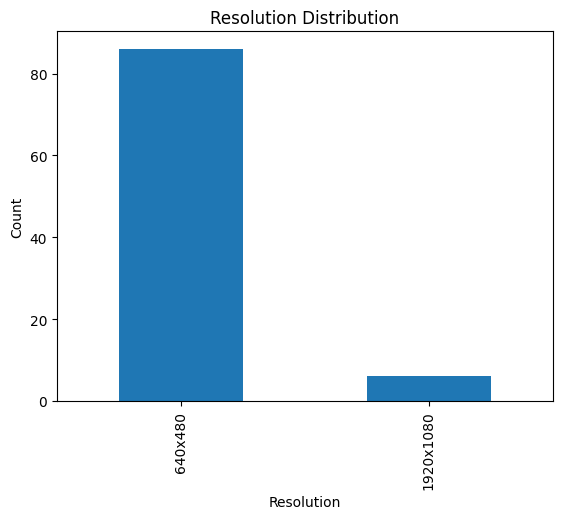

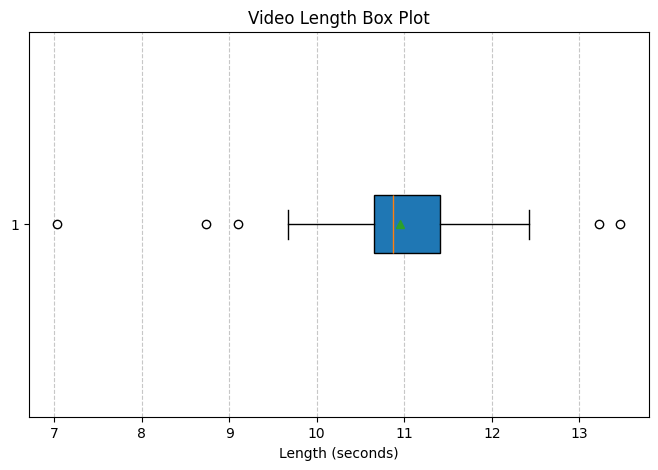

Shoplifting Class Summary Statistics:
Average Resolution: 640x480
Average FPS: 30.0
Average Length (s): 10.954347826086956
Average Size (MB): 4.1335869565217385
Longest Video (s): 13.47
Shortest Video (s): 7.03
Largest File (MB): 14.61
Smallest File (MB): 1.91


In [ ]:
summary_stats = analyze_video_data(video_info_Shoplifting)

print("Shoplifting Class Summary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

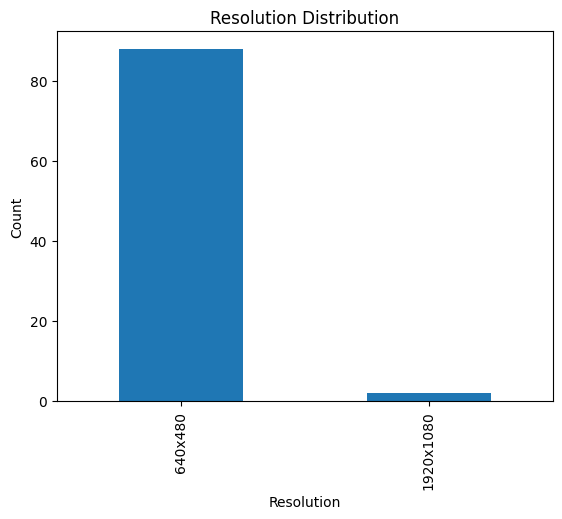

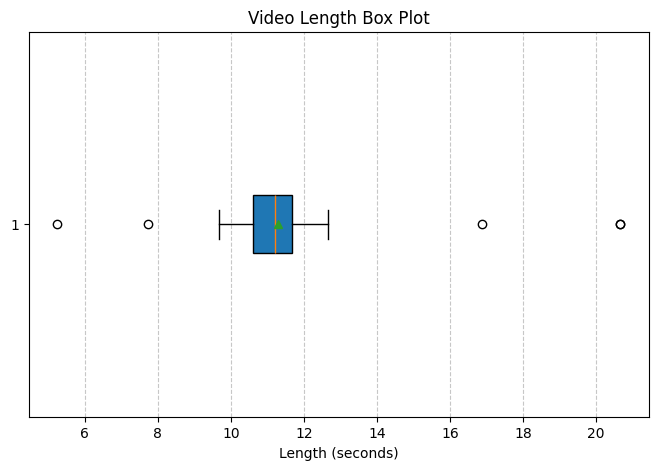

Normal Class Summary Statistics:
Average Resolution: 640x480
Average FPS: 30.0
Average Length (s): 11.284888888888888
Average Size (MB): 3.8586666666666662
Longest Video (s): 20.67
Shortest Video (s): 5.23
Largest File (MB): 23.42
Smallest File (MB): 1.49


In [ ]:
summary_stats = analyze_video_data(video_info_Normal)

print("Normal Class Summary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value}")

## Data pre-processing and visualization

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

In [4]:
DATASET_PATH = '/content/dataset/Shoplifting dataset'
SEQUENCE_LENGTH = 100
FRAME_SIZE = (224, 224)
AUGMENT_TIMES = 1
OUTPUT_PATH = '/content/preprocessed_data'

os.makedirs(OUTPUT_PATH, exist_ok=True)

# uniformly sample frames
def uniform_sampling(frames, num_samples):
    indices = np.linspace(0, len(frames) - 1, num_samples, dtype=int)
    return [frames[i] for i in indices]

# pad frames if a video is too short
def pad_frames(frames, num_samples):
    while len(frames) < num_samples:
        frames.append(frames[-1])  # Duplicate the last frame
    return frames[:num_samples]

# apply data augmentation
def augment_frame(frame):
    augmented_frame = cv2.flip(frame, 1)  # Flip along the y-axis
    return [augmented_frame]


# preprocess a single video
def preprocess_video(video_path, sequence_length, frame_size):
    cap = cv2.VideoCapture(video_path)
    frames = []

    # Extract all frames
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
        frame = cv2.resize(frame, frame_size)  # Resize to target size
        frames.append(frame)

    cap.release()

    # Handle short or long videos
    if len(frames) >= sequence_length:
        frames = uniform_sampling(frames, sequence_length)
    else:
        frames = pad_frames(frames, sequence_length)

    # Normalize pixel values to [0, 1]
    frames = [frame / 255.0 for frame in frames]
    return np.array(frames)

# process and save the dataset incrementally
def process_and_save_dataset(dataset_path, sequence_length, frame_size, augment_times, output_path):
    class_names = ['Normal', 'Shoplifting']

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        for video_file in os.listdir(class_path):
            video_path = os.path.join(class_path, video_file)
            if not video_file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
                continue

            try:
                # Preprocess the original video
                frames = preprocess_video(video_path, sequence_length, frame_size)
                video_data = [(frames, label)]

                # Generate augmented videos
                for _ in range(augment_times):
                    augmented_frames = []
                    for frame in frames:
                        augmented_frames.extend(augment_frame(frame))
                    augmented_frames = np.array(augmented_frames[:sequence_length])
                    video_data.append((augmented_frames, label))

                # Save processed video and augmentations incrementally
                for idx, (processed_frames, processed_label) in enumerate(video_data):
                    save_path = os.path.join(output_path, f"{class_name}_{video_file}_{idx}.pkl")
                    with open(save_path, 'wb') as file:
                        pickle.dump((processed_frames, processed_label), file)

            except Exception as e:
                print(f"Error processing video {video_path}: {e}")


print("Processing and saving dataset...")
process_and_save_dataset(DATASET_PATH, SEQUENCE_LENGTH, FRAME_SIZE, AUGMENT_TIMES, OUTPUT_PATH)
print("Dataset processing complete!")


Processing and saving dataset...
Error processing video /content/dataset/Shoplifting dataset/Normal/Normal (71).mp4: list index out of range
Dataset processing complete!


Original Label: 1, Augmented Label: 1


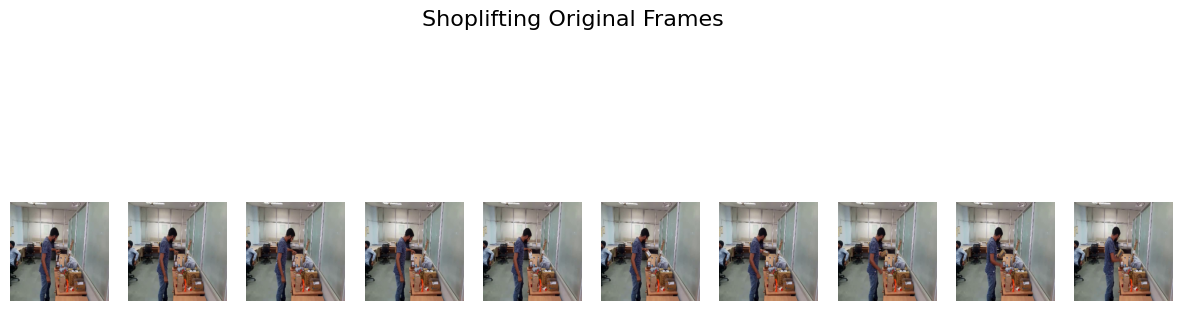

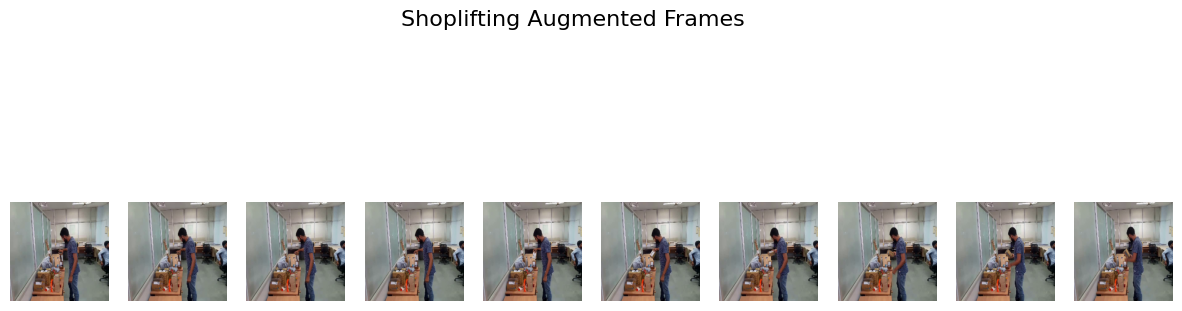

Original Label: 0, Augmented Label: 0


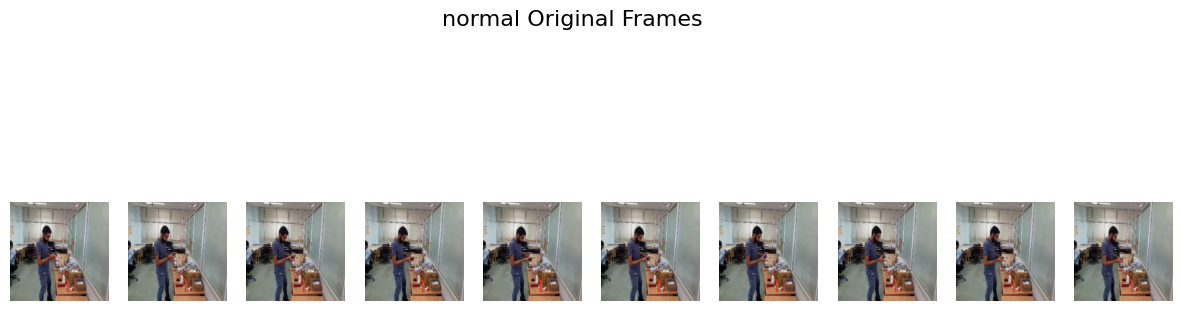

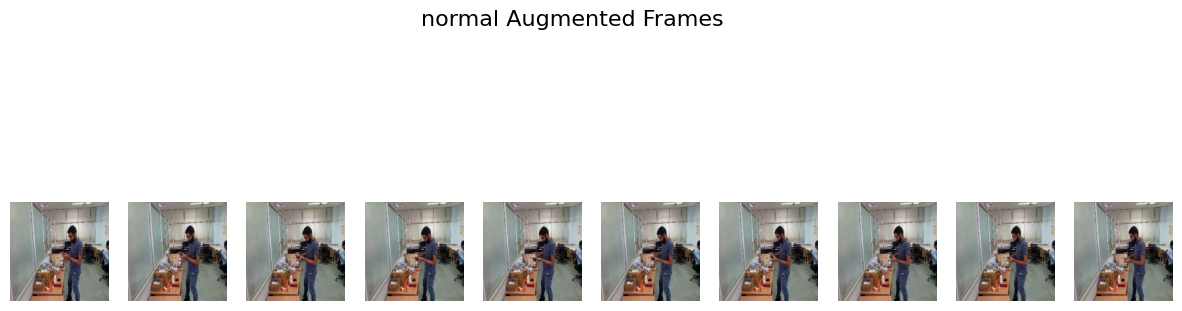

In [5]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np


# load a preprocessed .pkl file
def load_preprocessed_video(pkl_file_path):
    with open(pkl_file_path, 'rb') as file:
        frames, label = pickle.load(file)
    return frames, label

# visualize video frames
def visualize_video_frames(frames, title="Video Frames", num_frames=10):
    num_frames = min(num_frames, len(frames))  # Ensure we don't exceed the total number of frames
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i in range(num_frames):
        axes[i].imshow(frames[i])
        axes[i].axis('off')
    plt.show()


# Visualize original and augmented frames
Shoplifting_original_pkl = os.path.join(OUTPUT_PATH, "Shoplifting_Shoplifting (19).mp4_0.pkl")  # Original video
Shoplifting_augmented_pkl = os.path.join(OUTPUT_PATH, "Shoplifting_Shoplifting (19).mp4_1.pkl")  # Augmented version
normal_original_pkl = os.path.join(OUTPUT_PATH, "Normal_Normal (10).mp4_0.pkl")  # Original video
normal_augmented_pkl = os.path.join(OUTPUT_PATH, "Normal_Normal (10).mp4_1.pkl")  # Augmented version

# Load original and augmented frames
try:
    Shoplifting_original_frames, Shoplifting_original_label = load_preprocessed_video(Shoplifting_original_pkl)
    Shoplifting_augmented_frames, Shoplifting_augmented_label = load_preprocessed_video(Shoplifting_augmented_pkl)
    normal_original_frames, normal_original_label = load_preprocessed_video(normal_original_pkl)
    normal_augmented_frames, normal_augmented_label = load_preprocessed_video(normal_augmented_pkl)

    print(f"Original Label: {Shoplifting_original_label}, Augmented Label: {Shoplifting_augmented_label}")

    # Visualize original frames
    visualize_video_frames(Shoplifting_original_frames, title="Shoplifting Original Frames", num_frames=10)

    # Visualize augmented frames
    visualize_video_frames(Shoplifting_augmented_frames, title="Shoplifting Augmented Frames", num_frames=10)

    print(f"Original Label: {normal_original_label}, Augmented Label: {normal_augmented_label}")

    # Visualize original frames
    visualize_video_frames(normal_original_frames, title="normal Original Frames", num_frames=10)

    # Visualize augmented frames
    visualize_video_frames(normal_augmented_frames, title="normal Augmented Frames", num_frames=10)

except Exception as e:
    print(f"Error loading or visualizing data: {e}")



In [5]:
OUTPUT_PATH = '/content/preprocessed_data'
# Load and split the dataset into train, validation, and test sets
def load_and_split_dataset(output_path):
    data = []
    labels = []

    for file in os.listdir(output_path):
        file_path = os.path.join(output_path, file)
        with open(file_path, 'rb') as f:
            frames, label = pickle.load(f)
            data.append(frames)
            labels.append(label)

    data = np.array(data)
    labels = np.array(labels)

    X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


print("Loading and splitting dataset...")
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_split_dataset(OUTPUT_PATH)
print("Loading and splitting dataset copmleted")

Loading and splitting dataset...
Loading and splitting dataset copmleted


In [8]:
# Print data shapes
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Training data shape: (254, 100, 224, 224, 3), Training labels shape: (254,)
Validation data shape: (55, 100, 224, 224, 3), Validation labels shape: (55,)
Test data shape: (55, 100, 224, 224, 3), Test labels shape: (55,)



Save preprocessed and split data to Google Drive

In [ ]:
import pickle
from google.colab import drive


drive.mount('/content/drive')


def save_data(data, file_name):
    with open(file_name, 'wb') as file:
        pickle.dump(data, file)


drive_save_path = '/content/drive/My Drive/Shoplifting-data-splited/'

import os
if not os.path.exists(drive_save_path):
    os.makedirs(drive_save_path)


print("Saving processed and splitted data...")
save_data((X_train, y_train), os.path.join(drive_save_path, f'train_data_{SEQUENCE_LENGTH}.pkl'))
save_data((X_val, y_val), os.path.join(drive_save_path, f'val_data_{SEQUENCE_LENGTH}.pkl'))
save_data((X_test, y_test), os.path.join(drive_save_path, f'test_data_{SEQUENCE_LENGTH}.pkl'))

print("Data saving complete!")


Mounted at /content/drive
Saving processed and splitted data...
Data saving complete!


In [ ]:
import pickle
from google.colab import drive

drive.mount('/content/drive')

drive_save_path = '/content/drive/My Drive/Shoplifting-data-splited/'

def load_data(file_name):
    with open(file_name, 'rb') as file:
        return pickle.load(file)

# Load the data
train_data = load_data(os.path.join(drive_save_path, f'train_data_{SEQUENCE_LENGTH}.pkl'))
val_data = load_data(os.path.join(drive_save_path, f'val_data_{SEQUENCE_LENGTH}.pkl'))
test_data = load_data(os.path.join(drive_save_path, f'test_data_{SEQUENCE_LENGTH}.pkl'))

# Unpack the datasets
X_train, y_train = train_data
X_val, y_val = val_data
X_test, y_test = test_data

print("Data loaded successfully!")


## Model building and Training

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, Bidirectional, LSTM, Dense, Dropout, concatenate, GlobalAveragePooling2D, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import pickle



In [7]:
input_shape = (224, 224, 3)
sequence_length = 100
num_classes = 2


# CNN Branch 1
base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
cnn_input1 = Input(shape=input_shape)
x1 = base_model1(cnn_input1)
x1 = GlobalAveragePooling2D()(x1)
cnn1 = Model(cnn_input1, x1)

# CNN Branch 2
base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
cnn_input2 = Input(shape=input_shape)
x2 = base_model2(cnn_input2)
x2 = GlobalAveragePooling2D()(x2)
cnn2 = Model(cnn_input2, x2)


# TimeDistributed for each CNN branch
sequence_input1 = Input(shape=(sequence_length, 224, 224, 3))
sequence_input2 = Input(shape=(sequence_length, 224, 224, 3))
time_distributed1 = TimeDistributed(cnn1)(sequence_input1)
time_distributed2 = TimeDistributed(cnn2)(sequence_input2)


# Combine outputs from both CNN branches
combined_features = concatenate([time_distributed1, time_distributed2])


# RNN layer for temporal modeling
x = Bidirectional(LSTM(64, return_sequences=False))(combined_features)
#x = LSTM(128, return_sequences=False)(combined_features)
#x = GRU(128, return_sequences=False)(combined_features)
x = Dropout(0.6)(x)

# dense layers for classification
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)
output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=[sequence_input1, sequence_input2], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100, 224, 224, 3)]   0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 100, 224, 224, 3)]   0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 100, 1280)            2257984   ['input_5[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

filepath = '/content/CNNLSTM_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras'

checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_schedule = LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(-epoch / 20)
)


history = model.fit(
    [X_train, X_train],
    y_train,
    validation_data=([X_val, X_val], y_val),
    epochs=20,
    batch_size=8,
    callbacks=[checkpoint_callback, early_stopping, lr_schedule]
)


Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 2.1135 - accuracy: 0.5138 
Epoch 1: val_accuracy improved from -inf to 0.53704, saving model to /content/CNNLSTM_model_epoch_01_val_acc_0.54.keras
32/32 [==============================] - 1797s 55s/step - loss: 2.1135 - accuracy: 0.5138 - val_loss: 1.6857 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 1.7800 - accuracy: 0.5375 
Epoch 2: val_accuracy did not improve from 0.53704
32/32 [==============================] - 1757s 55s/step - loss: 1.7800 - accuracy: 0.5375 - val_loss: 1.5162 - val_accuracy: 0.5185 - lr: 8.9125e-04
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 1.4820 - accuracy: 0.6047 
Epoch 3: val_accuracy improved from 0.53704 to 0.55556, saving model to /content/CNNLSTM_model_epoch_03_val_acc_0.56.keras
32/32 [==============================] - 1753s 55s/step - loss: 1.4820 - accuracy: 0.6047 - val_loss: 1.3940 - val_accuracy: 0.

## Model Evaluation

In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the best-performing model
best_model = load_model('Bath of best performing model ')

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate([X_test, X_test], y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



2/2 - 86s - loss: 1.0999 - accuracy: 0.7818 - 86s/epoch - 43s/step
Test Loss: 1.0999256372451782
Test Accuracy: 0.7818182110786438


2/2 [==============================] - 80s 32s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        27
           1       0.83      0.71      0.77        28

    accuracy                           0.78        55
   macro avg       0.79      0.78      0.78        55
weighted avg       0.79      0.78      0.78        55

Confusion Matrix:
[[23  4]
 [ 8 20]]


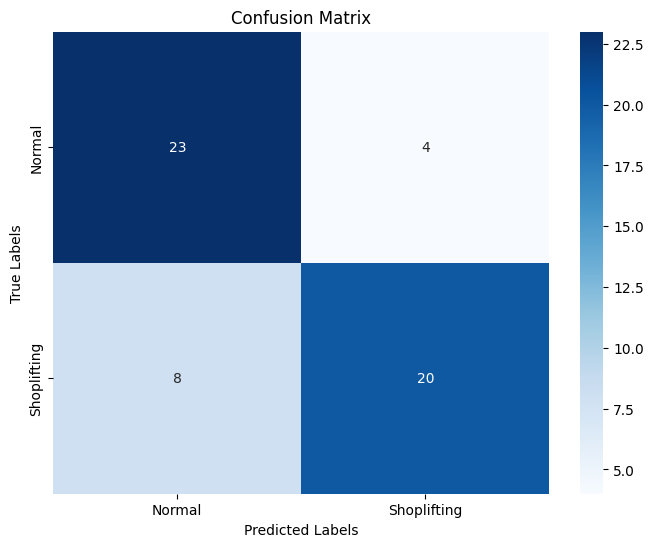

In [11]:
# Predict on the test set
y_pred_probs = best_model.predict([X_test, X_test])  # Get probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Shoplifting'] , yticklabels=['Normal', 'Shoplifting'] )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
